In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
import pyproj
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

- **센터 밖에서 진행한 코드**

# 데이터 읽기

In [2]:
#필요한 데이터 리스트
lst_yong = ['클러스터링\\data\\yong\\tbsh_gyeonggi_day_202404_용인시.csv','클러스터링\\data\\yong\\GG_TRANS_SEXAGE_ADMI_OUTFLOW_202404_4146_용인시.csv','클러스터링\\data\\yong\\GG_TRANS_SEXAGE_ADMI_INFLOW_202404_4146_용인시.csv','클러스터링\\data\\yong\\GG_PURPOSE_SEXAGE_ADMI_OD_202404_4146_용인시.csv','클러스터링\\data\\yong\\202404_202404_연령별인구현황_월간_용인.csv']

In [4]:
def input_csv(lst):
    df_card = pd.read_csv(lst[0])#카드 소비 데이터
    df_outflow = pd.read_csv(lst[1])#유츌 데이터
    df_inflow = pd.read_csv(lst[2])#유입 데이터
    df_od = pd.read_csv(lst[3])#od 데이터
    df_age = pd.read_csv(lst[4], encoding='cp949',thousands=',') #인구현황데이터
    return df_card, df_outflow, df_inflow, df_od, df_age

In [5]:
df_card_, df_outflow_, df_inflow_, df_od_, df_age_ = input_csv(lst_yong) #데이터 불러오기
gdf_gu_ = gpd_.read_file('클러스터링\\HangJeongDong_ver20230701.geojson') #행정동 경기데이터

In [101]:
df_yong_card = df_card_.copy()
df_yong_out = df_outflow_.copy()
df_yong_in = df_inflow_.copy()
df_age = df_age_.copy()
df_yong_od = df_od_.copy()
gdf_gu = gdf_gu_.copy()

# 1. 노인 인구 확인

In [89]:
#필요연령대, 행정동코드 추출, 행정 구역만 남기기
df_elder = df_age.iloc[:,[0,1,10,11,12,13]]
df_elder['행정동코드'] = df_elder['행정구역'].apply(lambda x: x[-11:-3])
df_elder['행정구역'] = df_elder['행정구역'].apply(lambda x:x[:-12])

C:\Users\귀여운 은순\AppData\Local\Temp\ipykernel_1536\2250674813.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_elder['행정동코드'] = df_elder['행정구역'].apply(lambda x: x[-11:-3])
C:\Users\귀여운 은순\AppData\Local\Temp\ipykernel_1536\2250674813.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_elder['행정구역'] = df_elder['행정구역'].apply(lambda x:x[:-12])


In [90]:
df_elder.columns

Index(['행정구역', '2024년04월_거주자_총인구수', '2024년04월_거주자_70~79세',
       '2024년04월_거주자_80~89세', '2024년04월_거주자_90~99세', '2024년04월_거주자_100세 이상',
       '행정동코드'],
      dtype='object')

In [91]:
# 컬럼명 변경
elder_col = ['행정구역','총인구','70~79세','80~89세','90~99세','100세_이상','행정동코드']
df_elder.columns = elder_col

In [92]:
# 70세_이상 인구 수와 비율 확인, 비율 순으로 정령
df_elder['70세_이상'] = np.sum(df_elder[['70~79세','80~89세','90~99세','100세_이상']], axis=1)
df_elder['70세_이상_비율'] = df_elder['70세_이상']/df_elder['총인구']
df_elder.sort_values(by='70세_이상_비율',ascending=False)

C:\Users\귀여운 은순\AppData\Local\Temp\ipykernel_1536\517771994.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_elder['70세_이상'] = np.sum(df_elder[['70~79세','80~89세','90~99세','100세_이상']], axis=1)
C:\Users\귀여운 은순\AppData\Local\Temp\ipykernel_1536\517771994.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_elder['70세_이상_비율'] = df_elder['70세_이상']/df_elder['총인구']


,행정구역,총인구,70~79세,80~89세,90~99세,100세_이상,행정동코드,70세_이상,70세_이상_비율
7,경기도 용인시 처인구 백암면,7930,1045,674,101,0,41461350,1820,0.229508
6,경기도 용인시 처인구 원삼면,7759,1003,517,98,1,41461340,1619,0.208661
24,경기도 용인시 기흥구 마북동,31123,2820,1552,217,9,41463570,4598,0.147736
23,경기도 용인시 기흥구 구성동,38923,3494,1866,270,6,41463560,5636,0.144799
4,경기도 용인시 처인구 이동읍,19756,1673,882,168,6,41461256,2729,0.138135
13,경기도 용인시 처인구 동부동,12557,1150,473,77,3,41461540,1703,0.135622
29,경기도 용인시 기흥구 보정동,34749,2756,1441,198,4,41463590,4399,0.126594
41,경기도 용인시 수지구 성복동,54335,4526,2066,244,3,41465590,6839,0.125867
3,경기도 용인시 처인구 모현읍,25935,2085,977,153,5,41461253,3220,0.124157
21,경기도 용인시 기흥구 기흥동,21072,1652,817,121,5,41463540,2595,0.123149


In [93]:
#구단위까지만 나와있는 값들 제거 (행정동까지 필요하기 때문)
admi_idx = df_elder['행정구역'].apply(lambda x : False if x.startswith('경기도 경기도') else True)
df_elder = df_elder[admi_idx]

In [94]:
# 다른 컬럼들과 idx 형태 맞춰주기
age_over_70 = df_elder['70세_이상_비율']
age_over_70.index = df_elder['행정동코드'].apply(lambda x:int(x))

In [111]:
age_over_70.head()

행정동코드
41461250    0.105204
41461253    0.124157
41461256    0.138135
41461259    0.112361
41461340    0.208661
Name: 70세_이상_비율, dtype: float64

## 1-1. 고령인구 비율과 지역맵 조인

In [98]:
# 기존 행정동코드와 맞게 교체
# 용인시 행정동코드만 가져옴
gdf_gu['adm_cd2'] = gdf_gu['adm_cd2'].apply(lambda x : int(x[:-2]))
gdf_gu = gdf_gu[gdf_gu['adm_cd2'].isin(age_over_70.index.to_list())]

In [99]:
# 데이터프레임 중 필요한 컬럼만 가져와서 이름 수정
gdf_dong = gdf_gu.iloc[:,[0,2,9]]
gdf_dong.columns = ['행정동명','행정동코드','geometry']

In [100]:
# 기존 행정동코드와 조인
gdf_elder = pd.merge(left=gdf_dong, right = age_over_70, on ='행정동코드')
gdf_elder.head()

,행정동명,행정동코드,geometry,70세_이상_비율
0,경기도 용인시처인구 포곡읍,41461250,"MULTIPOLYGON (((127.27860 37.30544, 127.28042 ...",0.105204
1,경기도 용인시처인구 모현읍,41461253,"MULTIPOLYGON (((127.28334 37.34531, 127.28316 ...",0.124157
2,경기도 용인시처인구 남사읍,41461259,"MULTIPOLYGON (((127.18870 37.08636, 127.18623 ...",0.112361
3,경기도 용인시처인구 이동읍,41461256,"MULTIPOLYGON (((127.17441 37.22459, 127.17541 ...",0.138135
4,경기도 용인시처인구 원삼면,41461340,"MULTIPOLYGON (((127.34840 37.20436, 127.34731 ...",0.208661


## 1-2. 고령인구비율 시각화
- 인터넷 문제로 센터분석실에서는 시각화 출력되지 않음

In [84]:
# 중앙 생성
center = [37.30544, 127.27860] 
geo_json_elder= gdf_elder.to_json()


# Create a map
m = folium.Map(location=center, zoom_start=13)

colormap = folium.LinearColormap(
    colors=['yellow', 'orange', 'red'],
    vmin=gdf_elder['70세_이상_비율'].min(),
    vmax=gdf_elder['70세_이상_비율'].max(),
    caption='70세_이상_비율'
)

# Add Choropleth layer
folium.Choropleth(
    geo_data=geo_json_elder,
    name='choropleth',
    data=gdf_elder,
    columns=['행정동명', '70세_이상_비율'], 
    key_on='feature.properties.행정동명',  
    fill_color='YlOrRd',  # Yellow to Red color scheme
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='70세_이상_비율',
    highlight=True
).add_to(m)

# Add the color map to the map
colormap.add_to(m)

m

# 2. 유입 유출 인구 확인

In [102]:
df_yong_in.head()

,ETL_YMD,D_TIME_CD,D_ADMI_CD,D_MEGA_NM,D_CTY_NM,D_ADMI_NM,D_CENTER_X,D_CENTER_Y,TRANS_GB,SEX_CD,AGE_GRP,CNT
0,20240401,15,41465520,경기도,용인시 수지구,풍덕천2동,963751,1924457,1,M,3,47.92
1,20240415,11,41465510,경기도,용인시 수지구,풍덕천1동,963985,1925518,3,W,5,33.84
2,20240424,11,41465580,경기도,용인시 수지구,상현2동,963457,1923011,1,W,4,10.13
3,20240404,15,41461526,경기도,용인시 처인구,삼가동,970329,1915750,1,W,2,4.23
4,20240427,1,41461510,경기도,용인시 처인구,중앙동,973438,1914058,1,W,5,10.88


In [103]:
# 70세_이상만 정보 획득
df_yong_in = df_yong_in[df_yong_in['AGE_GRP'] >= 8]
df_yong_out = df_yong_out[df_yong_out['AGE_GRP'] >= 8]

In [104]:
# 행정구역 정보로 합치고 합친 뒤 삭제
df_yong_in['행정구역'] = df_yong_in['D_MEGA_NM'] + ' ' + df_yong_in['D_CTY_NM'] + ' ' + df_yong_in['D_ADMI_NM']
df_yong_in = df_yong_in.drop(columns=['D_MEGA_NM',"D_CTY_NM","D_ADMI_NM"])

df_yong_out['행정구역'] = df_yong_out['O_MEGA_NM'] + ' ' + df_yong_out['O_CTY_NM'] + ' ' + df_yong_out['O_ADMI_NM']
df_yong_out = df_yong_out.drop(columns=['O_MEGA_NM',"O_CTY_NM","O_ADMI_NM"])

In [105]:
# 동별로 그룹바이 후 TRANS_GB로 value_counts
# 그 이후 피벗해서 행정구역별 이동수단 확인
# 차량:0, 노선버스:1, 지하철:2,도보:3, 고속버스:4, 기차:5, 항공:6, 기타:7
yong_vehicle_in = pd.DataFrame(df_yong_in.groupby(['D_ADMI_CD','행정구역']).TRANS_GB.value_counts()) 
yong_vehicle_in = yong_vehicle_in.pivot_table(columns='TRANS_GB',values='count',index='D_ADMI_CD')

yong_vehicle_out = pd.DataFrame(df_yong_out.groupby(['O_ADMI_CD','행정구역']).TRANS_GB.value_counts()) 
yong_vehicle_out = yong_vehicle_out.pivot_table(columns='TRANS_GB',values='count',index='O_ADMI_CD')

In [106]:
# 보기 좋게 컬럼명 재설정
yong_vehicle_col = ['차량','노선버스','지하철','도보','고속버스','기차','항공','기타']
yong_vehicle_in.columns = yong_vehicle_col
yong_vehicle_out.columns = yong_vehicle_col

In [107]:
# 유입인구, 유출인구 확인
yong_vehicle_in['유입인구'] = np.sum(yong_vehicle_in,axis=1)
yong_vehicle_out['유출인구'] = np.sum(yong_vehicle_out,axis=1)

In [108]:
# 유입, 유출시 차량비율 확인
yong_vehicle_in['입차비율'] = yong_vehicle_in['차량'] / yong_vehicle_in['유입인구']
yong_vehicle_out['출차비율'] = yong_vehicle_out['차량'] / yong_vehicle_out['유출인구']
yong_car_out = yong_vehicle_out['출차비율']
yong_car_in = yong_vehicle_in['입차비율']

In [109]:
# 유입과 유출의 평균으로 데이터 프레임 생성
yong_car = pd.concat([yong_car_out,yong_car_in],axis=1)
yong_car['입출차비율'] = (yong_car['입차비율'] + yong_car['출차비율'])/2
yong_car = yong_car.drop(columns = ['출차비율','입차비율'])

In [112]:
yong_car = yong_car.reset_index()
yong_car.columns = ['행정동코드', '입출차비율']
yong_car.head()

,행정동코드,입출차비율
0,41461250,0.330190
1,41461253,0.357527
2,41461256,0.463438
3,41461259,0.417935
4,41461340,0.599342


In [114]:
# 기존 행정동코드와 조인
gdf_car = pd.merge(left=gdf_dong, right = yong_car, on ='행정동코드')
gdf_car.head()

,행정동명,행정동코드,geometry,입출차비율
0,경기도 용인시처인구 포곡읍,41461250,"MULTIPOLYGON (((127.27860 37.30544, 127.28042 ...",0.330190
1,경기도 용인시처인구 모현읍,41461253,"MULTIPOLYGON (((127.28334 37.34531, 127.28316 ...",0.357527
2,경기도 용인시처인구 남사읍,41461259,"MULTIPOLYGON (((127.18870 37.08636, 127.18623 ...",0.417935
3,경기도 용인시처인구 이동읍,41461256,"MULTIPOLYGON (((127.17441 37.22459, 127.17541 ...",0.463438
4,경기도 용인시처인구 원삼면,41461340,"MULTIPOLYGON (((127.34840 37.20436, 127.34731 ...",0.599342


In [116]:
# 중앙 생성
center = [37.30544, 127.27860] 
geo_json_car= gdf_car.to_json()


# Create a map
m = folium.Map(location=center, zoom_start=12)

colormap = folium.LinearColormap(
    colors=['yellow', 'orange', 'red'],
    vmin=gdf_car['입출차비율'].min(),
    vmax=gdf_car['입출차비율'].max(),
    caption='입출차비율'
)

# Add Choropleth layer
folium.Choropleth(
    geo_data=geo_json_car,
    name='choropleth',
    data=gdf_car,
    columns=['행정동명', '입출차비율'], 
    key_on='feature.properties.행정동명',  
    fill_color='YlOrRd',  # Yellow to Red color scheme
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='입출차비율',
    highlight=True
).add_to(m)

# Add the color map to the map
colormap.add_to(m)

m

# 3. 고령인구의 소비확인

In [11]:
df_yong_card.head()

,ta_ymd,cty_rgn_no,admi_cty_no,card_tpbuz_cd,card_tpbuz_nm_1,card_tpbuz_nm_2,hour,sex,age,day,amt,cnt
0,20240401,41461,41461250,D01,소매/유통,가전제품,1,F,2,1,41604,17
1,20240401,41461,41461250,D01,소매/유통,가전제품,1,F,3,1,971391,189
2,20240401,41461,41461250,D01,소매/유통,가전제품,1,F,4,1,755990,145
3,20240401,41461,41461250,D01,소매/유통,가전제품,1,F,5,1,268970,69
4,20240401,41461,41461250,D01,소매/유통,가전제품,1,F,6,1,260681,67


In [12]:
# 나이 70세_이상
df_yong_card = df_yong_card[df_yong_card['age'] >= 7]

## 3-1. 전반적인 소비 확인 
- 총 순위
1. 소매/유통
2. 음식
3. 의료/건강
4. 생활서비스

In [13]:
df_yong_card.groupby('card_tpbuz_nm_1').agg({'cnt':'sum'}).sort_values(by='cnt', ascending=False)

,cnt
card_tpbuz_nm_1,
소매/유통,2278840
음식,1145021
의료/건강,597649
생활서비스,580195
여가/오락,98461
미디어/통신,76405
공공/기업/단체,28168
학문/교육,18737
공연/전시,2740


<Axes: xlabel='card_tpbuz_nm_1'>

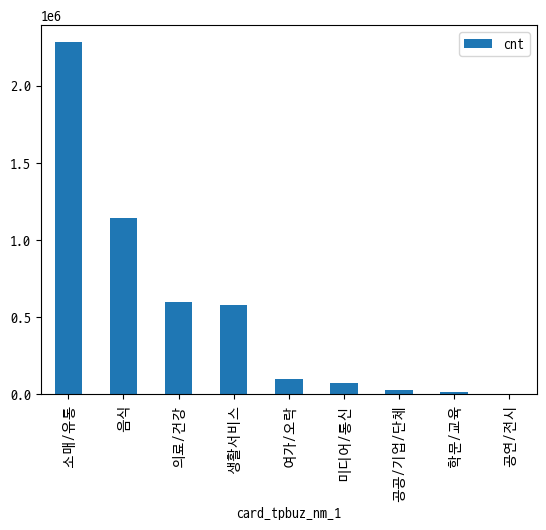

In [14]:
#분야별 소비건수 확인
df_yong_card.groupby('card_tpbuz_nm_1').agg({'cnt':'sum'}).sort_values(by='cnt', ascending=False).plot(kind='bar')

In [31]:
df_yong_card[df_yong_card['card_tpbuz_nm_1'] == '소매/유통'].groupby('card_tpbuz_nm_2').agg({'cnt':'sum'}).sort_values(by='cnt',ascending=False)

,cnt
card_tpbuz_nm_2,
종합소매점,1455471
음/식료품소매,354739
의복/의류,98589
제조/도매,88458
가전제품,67908
화장품소매,49068
선물/완구,39330
인테리어/가정용품,35568
스포츠/레져용품,22019


<Axes: xlabel='card_tpbuz_nm_2'>

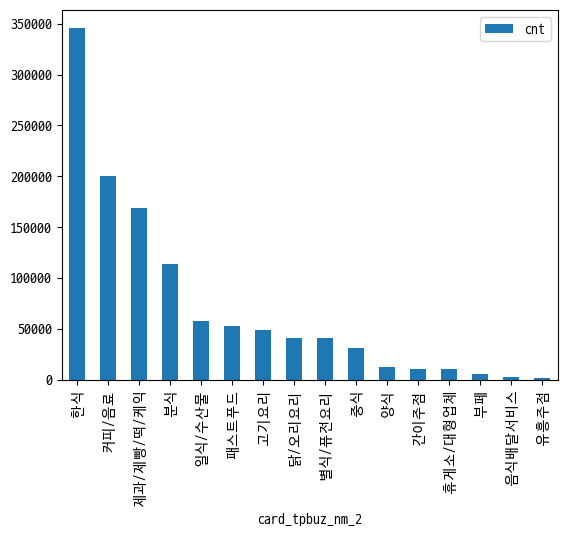

In [17]:
#음식 분야별 매출건수 확인
df_yong_card[df_yong_card['card_tpbuz_nm_1'] == '음식'].groupby('card_tpbuz_nm_2').agg({'cnt':'sum'}).sort_values(by='cnt',ascending=False).plot(kind='bar')

<Axes: xlabel='card_tpbuz_nm_2'>

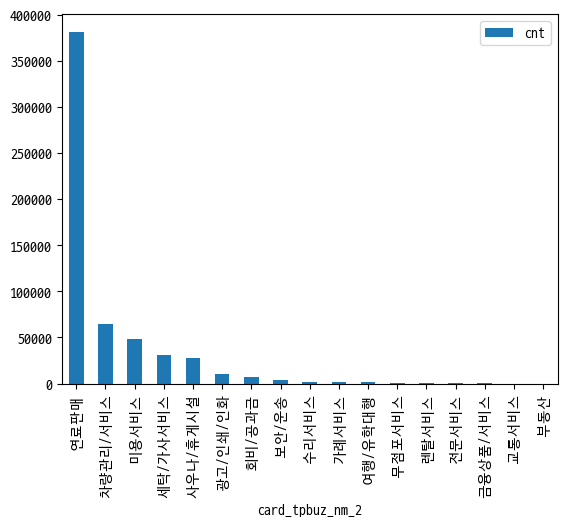

In [18]:
#생활서비스 분야별 매출건수 확인
df_yong_card[df_yong_card['card_tpbuz_nm_1'] == '생활서비스'].groupby('card_tpbuz_nm_2').agg({'cnt':'sum'}).sort_values(by='cnt',ascending=False).plot(kind='bar')

<Axes: xlabel='card_tpbuz_nm_2'>

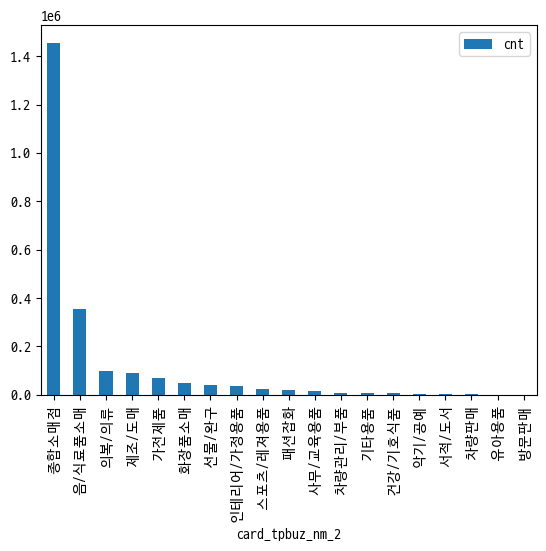

In [16]:
#소매/유통 분야별 매출건수 확인
df_yong_card[df_yong_card['card_tpbuz_nm_1'] == '소매/유통'].groupby('card_tpbuz_nm_2').agg({'cnt':'sum'}).sort_values(by='cnt',ascending=False).plot(kind='bar')

<Axes: xlabel='card_tpbuz_nm_2'>

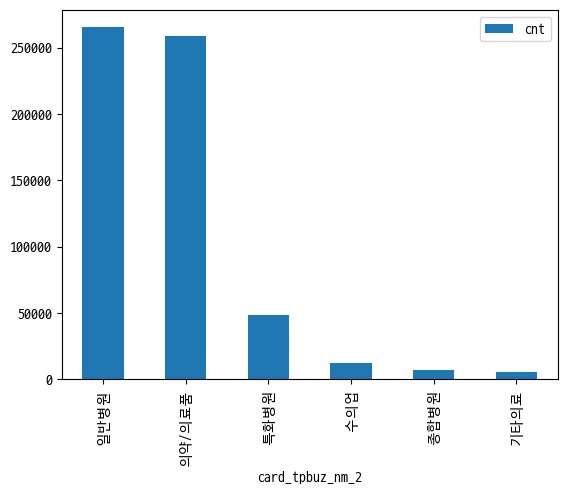

In [15]:
#의료/건강 분야별 매출건수 확인
df_yong_card[df_yong_card['card_tpbuz_nm_1'] == '의료/건강'].groupby('card_tpbuz_nm_2').agg({'cnt':'sum'}).sort_values(by='cnt',ascending=False).plot(kind='bar')

In [32]:
df_yong_card[df_yong_card['card_tpbuz_nm_1'] == '의료/건강'].groupby('card_tpbuz_nm_2').agg({'cnt':'sum'}).sort_values(by='cnt',ascending=False)

,cnt
card_tpbuz_nm_2,
일반병원,265190
의약/의료품,258909
특화병원,48572
수의업,12441
종합병원,6855
기타의료,5682


## 3-2. 필요한 소비만 추출

In [117]:
#'의료/건강','소매/유통' 소비만 추출
admi_yong_card = df_yong_card.groupby(['admi_cty_no','card_tpbuz_nm_1']).agg({'cnt':'sum'}).pivot_table(columns='card_tpbuz_nm_1',index='admi_cty_no',values='cnt')
hos_mart_card = admi_yong_card.iloc[:,[4,7]].sort_values(by=['의료/건강','소매/유통'],ascending=False)

In [118]:
hos_mart_card.head()

card_tpbuz_nm_1,소매/유통,의료/건강
admi_cty_no,,
41461510,525094.0,198110.0
41465590,630705.0,143332.0
41465520,340508.0,138737.0
41463577,166646.0,116303.0
41463520,557183.0,109146.0


# 4. OD 데이터 확인

## 4-1. 위도,경도 확인

In [144]:
# 나이 70세_이상
df_yong = df_yong_od[df_yong_od['AGE_GRP'] >= 8]

# 도착지와 출발지가 용인시인 곳
df_yong = df_yong[df_yong['D_CTY_NM'].str.startswith('용인시', na=False)]
df_yong = df_yong[df_yong['O_CTY_NM'].str.startswith('용인시', na=False)]


#행정동안에서의 이동 제거
df_yong=df_yong[df_yong['O_ADMI_NM']!=df_yong['D_ADMI_NM']]

# 필요한 컬럼만 가져오기
df_yong_o = df_yong[['O_ADMI_CD','O_CENTER_X','O_CENTER_Y']]
df_yong_d = df_yong[['D_ADMI_CD','D_CENTER_X','D_CENTER_Y']]

# 중복제거
df_yong_o = df_yong_o.drop_duplicates()
df_yong_d = df_yong_d.drop_duplicates()

In [145]:
#좌표변환
출발_xy=df_yong_o[df_yong_o.columns[1:3]]
도착_xy=df_yong_d[df_yong_d.columns[1:3]]

import pyproj
import numpy as np

def project_array(coord, p1_type, p2_type):
    """
    좌표계 변환 함수
    - coord: x, y 좌표 정보가 담긴 NumPy Array
    - p1_type: 입력 좌표계 정보 ex) epsg:5179
    - p2_type: 출력 좌표계 정보 ex) epsg:4326
    """
    p1 = pyproj.Proj(init=p1_type)
    p2 = pyproj.Proj(init=p2_type)
    fx, fy = pyproj.transform(p1, p2, coord[:, 0], coord[:, 1])
    return np.dstack([fx, fy])[0]

## 좌표계 정보 설정
p1_type = "epsg:5179"
p2_type = "epsg:4326"

## DataFrame -> NumPy Array 변환
xy_ar=np.array(출발_xy)
# project_array() 함수 실행
출발_result = project_array(xy_ar, p1_type, p2_type)
df_yong_o['출발_경도']=출발_result[:,0]
df_yong_o['출발_위도']=출발_result[:,1]

xy_ar=np.array(도착_xy)
도착_result = project_array(xy_ar, p1_type, p2_type)
df_yong_d['도착_경도']=도착_result[:,0]
df_yong_d['도착_위도']=도착_result[:,1]
df_yong_o.head(),df_yong_d.head()

C:\Python310\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Python310\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\귀여운 은순\AppData\Local\Temp\ipykernel_1536\551834547.py:17: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  fx, fy = pyproj.transform(p1, p2, coo

(     O_ADMI_CD  O_CENTER_X  O_CENTER_Y       출발_경도      출발_위도
 42    41463516      962789     1919621  127.080272  37.274763
 191   41461259      969498     1903821  127.156592  37.132587
 272   41465540      967177     1926062  127.129482  37.332986
 294   41465530      960832     1926008  127.057862  37.332254
 297   41465510      963985     1925518  127.093476  37.327964,
      D_ADMI_CD  D_CENTER_X  D_CENTER_Y       도착_경도      도착_위도
 42    41463586      968384     1918150  127.143443  37.261711
 191   41461525      972180     1915862  127.186338  37.241208
 272   41461510      973438     1914058  127.200586  37.224984
 294   41461530      974474     1917227  127.212155  37.253578
 297   41465580      963457     1923011  127.087640  37.305346)

In [146]:
df_yong_o.set_index('O_ADMI_CD',inplace=True,drop=True)
df_yong_d.set_index('D_ADMI_CD',inplace=True,drop=True)

In [154]:
yong_pos = pd.concat([df_yong_o[['출발_위도','출발_경도']],df_yong_d[['도착_위도','도착_경도']]],axis=1).drop_duplicates()
yong_pos = yong_pos.iloc[:,:2]
yong_pos = yong_pos.reset_index()
yong_pos.columns = ['행정동코드','위도','경도']
yong_pos.head()

,행정동코드,위도,경도
0,41463516,37.274763,127.080272
1,41461259,37.132587,127.156592
2,41465540,37.332986,127.129482
3,41465530,37.332254,127.057862
4,41465510,37.327964,127.093476


## 4-2. 연결 경로 확인하기

In [185]:
df_path = df_yong_od[df_yong_od['O_ADMI_CD'] == 41461510]
df_path = df_path[df_path['AGE_GRP'] >= 8]
df_path = df_path.dropna()
df_path = df_path[(df_path['D_CTY_NM'].str.startswith('용인시'))]
df_path = df_path.iloc[:,[1,7,16]]
df_path = df_path[df_path['O_ADMI_CD'] != df_path['D_ADMI_CD']]
df_path

,O_ADMI_CD,D_ADMI_CD,CNT
498,41461510,41461360,22.58
2926,41461510,41463540,8.23
3088,41461510,41461525,61.65
3497,41461510,41463575,14.15
5710,41461510,41463530,3.55
...,...,...,...
6691431,41461510,41465510,1.96
6691799,41461510,41463577,4.12
6694267,41461510,41461253,9.00
6695485,41461510,41461526,7.23


In [187]:
df_od_group = df_path.groupby(['O_ADMI_CD','D_ADMI_CD']).agg({"CNT":"sum"})
df_od_group = df_od_group.reset_index()
df_od_group.head()

,O_ADMI_CD,D_ADMI_CD,CNT
0,41461510,41461250,6686.96
1,41461510,41461253,1667.10
2,41461510,41461256,5948.91
3,41461510,41461259,2346.99
4,41461510,41461340,2355.70


In [188]:
# 1. 출발지 경도 및 위도 추가 (O_ADMI_CD를 기준으로 조인)
df_od = df_od_group.merge(yong_pos, how='left', left_on='O_ADMI_CD', right_on='행정동코드')
df_od.rename(columns={'경도': '출발_경도', '위도': '출발_위도'}, inplace=True)
df_od.drop(columns=['행정동코드'], inplace=True)

# 2. 도착지 경도 및 위도 추가 (D_ADMI_CD를 기준으로 조인)
df_od = df_od.merge(yong_pos, how='left', left_on='D_ADMI_CD', right_on='행정동코드')
df_od.rename(columns={'경도': '도착_경도', '위도': '도착_위도'}, inplace=True)
df_od.drop(columns=['행정동코드'], inplace=True)

# 최종 결과 출력
df_od.head()

,O_ADMI_CD,D_ADMI_CD,CNT,출발_위도,출발_경도,도착_위도,도착_경도
0,41461510,41461250,6686.96,37.224984,127.200586,37.290503,127.217577
1,41461510,41461253,1667.10,37.224984,127.200586,37.326443,127.218255
2,41461510,41461256,5948.91,37.224984,127.200586,37.164679,127.211141
3,41461510,41461259,2346.99,37.224984,127.200586,37.132587,127.156592
4,41461510,41461340,2355.70,37.224984,127.200586,37.163270,127.313292


## 4-3. OD 강도 시각화

In [190]:
# Create a map centered on the average of the starting positions
m = folium.Map(location=[df_od['출발_위도'].mean(), df_od['출발_경도'].mean()], zoom_start=12)

# Normalize CNT values to use for transparency (opacity)
min_cnt = df_od['CNT'].min()
max_cnt = df_od['CNT'].max()

# Function to normalize CNT values to opacity between 0.1 and 1
def normalize(cnt, min_cnt, max_cnt):
    return (cnt - min_cnt) / (max_cnt - min_cnt) * (1 - 0.1)

folium.GeoJson(gdf_gu, 
               name="경계면").add_to(m)

threshold = 5000

# Plot lines between start and end points with color based on CNT
for _, row in df_od.iterrows():
    opacity = normalize(row['CNT'], min_cnt, max_cnt)  # Normalize CNT for opacity
    folium.PolyLine(
        locations=[(row['출발_위도'], row['출발_경도']), (row['도착_위도'], row['도착_경도'])],
        color='red',  # You can change the color here
        weight=5,      # Thickness of the line
        opacity=opacity*1.5  # Opacity based on CNT
    ).add_to(m)

    if row['CNT'] > threshold:
        folium.Marker(
            location=[row['도착_위도'], row['도착_경도']],
            popup=f"도착지: {row['도착_위도']}, {row['도착_경도']}",
            icon=folium.Icon(color='blue', icon='info-sign')
        ).add_to(m)

        folium.Marker(
            location=[row['출발_위도'], row['출발_경도']],
            popup=f"도착지: {row['출발_위도']}, {row['출발_경도']}",
            icon=folium.Icon(color='green', icon='info-sign')
        ).add_to(m)

m

# 5. 전처리 된 데이터 저장하기
이후 안심데이터와 결합

In [ ]:
age_over_70.to_csv('preYongElder.csv') # 고령인구 데이터
hos_mart_card.to_csv('preYongCard.csv') # 카드소비 데이터 >> 결합
yong_car.to_csv('pyeYongCar.csv') # 입출차비율 데이터